# Controlling the self-assembly of de novo designed amyloid structures

<img src="images/illustration.png" width="650" align="center"/>

## Introduction

### What is this?
This is a notebook covering some of the data analysis conducted in my masters thesis "Controlling the self-assembly of de novo designed amyloid structures" which is available as a PDF in the folder thesis. The results have not been published as a result of the project not being finished. The notebook is part of the Jupyter course carried out at the Univeristy of Lund.

### What was the goal?
The goal of the thesis was to develope a design protocol to design amyloid protein assemblies containing coordinated zinc atoms. Removal and addition of zinc is supposed to act as an actuator promoting self-assembly when present, and depromote it when absent (see figure above). Thus the self-assembly of the amyloid structures can be controlled. De novo refers to the fact that these are distinct from natural proteins because we design the sequence.

### What will be analyzed?
To design the amyloid structures it was important to correctly parametrize the coordinationsphere of zinc, and to appropiately sample the loop regions by assigning the sampling space to appropiate torsion angles. In both cases, analysis of crystal structures deposited in the Protein Data Bank were carried out. The analysis of the zinc coordinationsphere is discussed further in section 1. The analysis of the torsion angles to use in loop sampling is discussed further in section 2. 

### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl; mpl.use("nbagg")
import matplotlib.pyplot as plt
import scipy.stats as st

## 1:  Parametrization of zincs coordinationsphere in proteins

### Monuclear Tetrahedral zinc sites

To make the modelling as simple as possible, zinc is modelled as mononuclear, that is only with only 1 zinc atom per site, and with a tetrahedral coordination sphere. The tetrahedral coordination sphere is shown below. In this geometry zinc has 4 ligands coordinated at very specific positions with an angle of 109.5 / 120 degrees between them. Residues such histidine can coordinate to zinc through either of its nitrogen atoms. The following analysis will only focus on the binding geometry from the NE2 atom of histidine. Although 9 other binding modes and 3 other residues were orignally analyzed, the approach is exactly the same.

<img src="images/tetrahedral_zn.png" width="450" align="center"/>

### 6 coordination parameters

To further parametrize the coordinationsphere in proteins, zinc sites identified in approx 3000 crystal structures deposited in the [Protein Data Bank](http://www.rcsb.org) (PDB) were analyzed. Two overall datasets were constructed: Dataset 1. contained all zinc sites identified in the PDB and Dataset 2 only mononuclear tetrahedral zinc sites (see figure below). Both datasets were used to obtain values for 3 other datasets each for 3 specific coordination parameters as seen below. 

<img src="images/analysis.png" width="600" align="center"/>

**Dataset 1** was used to obtain datasets for the following parameters named $D$, $A_B$, $T_B$:
- $D$:    The distance between ZN and NE2
- $A_B$:  The angle between ZN, NE2 and CE1
- $T_B$:  The torsion angle between ZN, NE2, CE1 and 

**Dataset 2** was used to obtain the following parameters named $A_A$, $T_A$, $T_{AB}$:
- $A_A$:  The angle between another ligand (L1), ZN and NE2
- $T_A$:  The torsion angle between two other ligands (L1 and L2), ZN and NE2
- $T_{AB}$: The torsion angle between L1, ZN, NE2 and CE1

In the following analysis the 6 parameters are assumed independent. The datasets are used to obtain probability distributions for each parameter and known probability distribution functions (PDFs) are then fitted to each parameter. This is done to identify optimal values for each parameter, but also the "flexibilty" which is modelled through the standard deviation. These values are used to sample the zinc coordinationsphere using the [Rosetta match alogrithm](https://onlinelibrary.wiley.com/doi/full/10.1110/ps.062353106) and to constrain the movement of coordinating residues in downstream optimization steps.

## Analysis

### Read in the datasets

The 2 overall datasets are available in the folder data. These are read in the following and the headers are renamed.

In [2]:
df1 = pd.read_csv('data/all_sites.csv', names=['$D$','$A_B$', '$T_B$'], header=1)
df2 = pd.read_csv('data/mono_sites.csv', names=['$A_A$', '$T_A$', '$T_{AB}$'], header=1)
df = pd.concat([df1, df2], sort=False, axis=1)
df.index.name = "Observation"
df.head()

,$D$,$A_B$,$T_B$,$A_A$,$T_A$,$T_{AB}$
Observation,,,,,,
0,2.014566,124.318687,184.935623,120.867180,67.479599,301.351891
1,2.411251,116.806465,178.742432,8.241096,135.076431,288.024887
2,2.031784,122.995079,190.265991,105.395515,167.603287,181.337494
3,1.877313,138.164032,170.087784,104.553619,8.127820,55.358089
4,2.077349,123.345840,179.039169,94.447151,2.054523,290.895294


### Fitting probability distrubtuins to the datasets

Each of the datasets are binned into a normalized histrogram that represents the probability distribution of the data. The histrograms consists of 50 bins and the height ($h_j$) of each bin (j) was set and normalized according to:

\begin{align}
h_j = \dfrac{y_j}{n \cdot b}
\end{align}

where n is the sum of all data points for the parameter, $y_j$ is the amount of data points in the jth bin, and b is the bin width.

Originally, all of the available probability distribution in the SciPy module was fitted to the parameters. At the time 81 distributions were available and these are given in the list below:

In [3]:
all_distributions = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

The 2 functions below (best_fit_distribution and make_pdf) are able to fit all of the distrubtions for each parameter and evaluate the best fit according to the least sum of squared errors (SSE). The SSE is calculated as below:

\begin{align}
SSE = \sum_{j=1}^{50} {(h_j - PDF_j)}^2
\end{align}

where $h_j$ is the same as before, and $PDF_j$ is the height of that PDF at the center of the bin. The best PDFs are the ones having the lowest SSE.

Due to long execution time (a couple of minutes) only 1 distribution is fitted for each parameter in this notebook. The user can test the functions below for all distributions by supplying the above list to the functions (see later).

In [4]:
def best_fit_distribution(data, distributions, bins=50):
    """ Model data by finding best fit distribution to data """
   
    # Make a normalized histogram and return the bin heights h
    n = len(data)
    y, x = np.histogram(data, bins=bins) # returns height of each bin y, and bin edges x
    x = (x + np.roll(x, -1))[:-1] / 2.0 # get the centers of the bins from the bin edges
    bindwidth = x[1] - x[0] 
    h = [y[i] / (n * bindwidth) for i in range(len(y)) ] # normalize the bin heights
    
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in distributions:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # Fit dist to data
                params = distribution.fit(data) # parameters returned from fit

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(h - pdf, 2.0)) # sum of squared errors

                # identify if this distribution is better / compare sse's
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass
        
    return (best_distribution.name, best_params)

In [5]:
def make_pdf(dist, data, params, bins=50, size=100000):
    """ Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get same start and end points of distribution
    y, x = np.histogram(data, bins=bins)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    start = min(x)
    end = max(x)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    dist = getattr(st, dist)
    pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
    
    return (x, pdf)

The code below uses the above two functions to fit and plot the histograms along with the fit, maximum values and standard deviation. Note that the distributions parameter is a list of list of distributions (one for each parameter), and is not the same as supplied to the functions above. To fit all the distrubutions use ``[all_distrubutions]*3`` as a parameter instead. 

In [6]:
def plot_geometry_dist(df, distributions,  xlabels, title, skip=[], significant=None, bins=50):

    # setup figures and axes
    fig, axes = plt.subplots(1,3, figsize=(9.5,4))
    fig.subplots_adjust(left=None, bottom=0.2, right=None, top=0.8, wspace=0.1, hspace=0.3)
    fig.suptitle(title)

    current = 1; 
    for bm, xlabel, ax, dist in zip(df.columns, xlabels, axes, distributions):
        
        # remove NaN values from datasets
        data = df[bm].dropna()
    
        # plot histogram
        ax.hist(data, bins, edgecolor='black', linewidth=0.4, density=True, color='royalblue', label="_")

        # whether or not to plot the PDF
        if current not in skip:
            
            # obtain fit data
            best_fit, best_params = best_fit_distribution(data, dist, bins)
            x, pdf = make_pdf(best_fit, data, best_params, bins)
            std = round(np.std(data), 2)
            opt = round(x[np.argmax(pdf)],2)
    
            # plot PDF
            ax.plot(x, pdf, color='black', linestyle='-', linewidth=1)
            
            # determine significant numbers and mark maximum and standard devation
            if significant and current==significant:
                ax.axvline(opt, color='k', linestyle='--', linewidth=1, label = "max = " + '{0:.2f}'.format((opt)))
                ax.axvline(opt + std, color='k', linestyle=':', linewidth=1, label = r'$\sigma$' + ' = ' + r'$\pm$' + '{0:.2f}'.format((round(std,2))) )
            else:
                ax.axvline(opt, color='k', linestyle='--', linewidth=1, label = "max = " + '{0:.0f}'.format((opt)))
                ax.axvline(opt + std, color='k', linestyle=':', linewidth=1, label = r'$\sigma$' + ' = ' + r'$\pm$' + '{0:.0f}'.format((round(std,2))) )
            ax.axvline(opt - std, color='k', linestyle=':', linewidth=1)
            ax.legend(loc='best', fontsize=7)
        
        # set labels
        ax.set_title(bm, fontsize=15)
        ax.set_xlabel(xlabel,  fontsize=13)
        ax.set_ylabel("Density (rel)")
    
        # remove some spines and ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        
        current +=1
        
        plt.show()

First the distrubutions are plotted for **Dataset 1**. ``st.johnsonsu`` is used for the $D$ parameter while ``st.norm`` is used for rest.

<IPython.core.display.Javascript object>


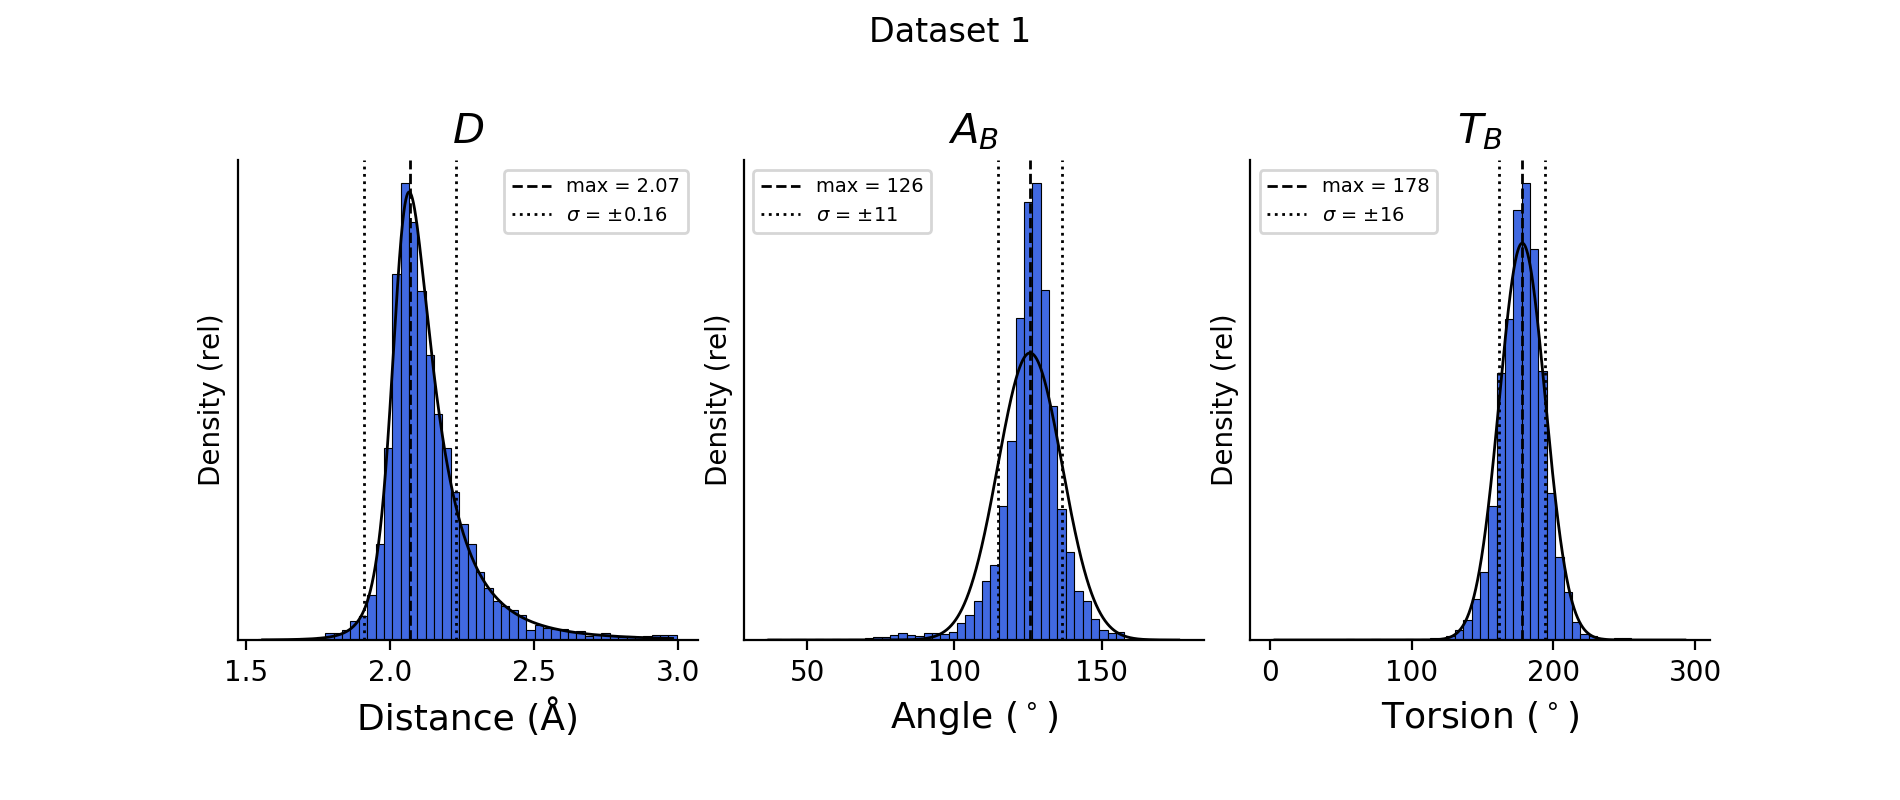

In [7]:
plot_geometry_dist(df.iloc[:, 0:3], [[st.johnsonsu], [st.norm], [st.norm]], 
                   ['Distance ' + u'(Å)', r'Angle ($^\circ$)', r'Torsion ($^\circ$)'], 'Dataset 1', significant=1)

Then the distrubutions are plotted for the **Dataset 2**. No fit is carried out for the $T_{AB}$ parameter (discussed below) and ``st.norm`` is used for the others.

<IPython.core.display.Javascript object>


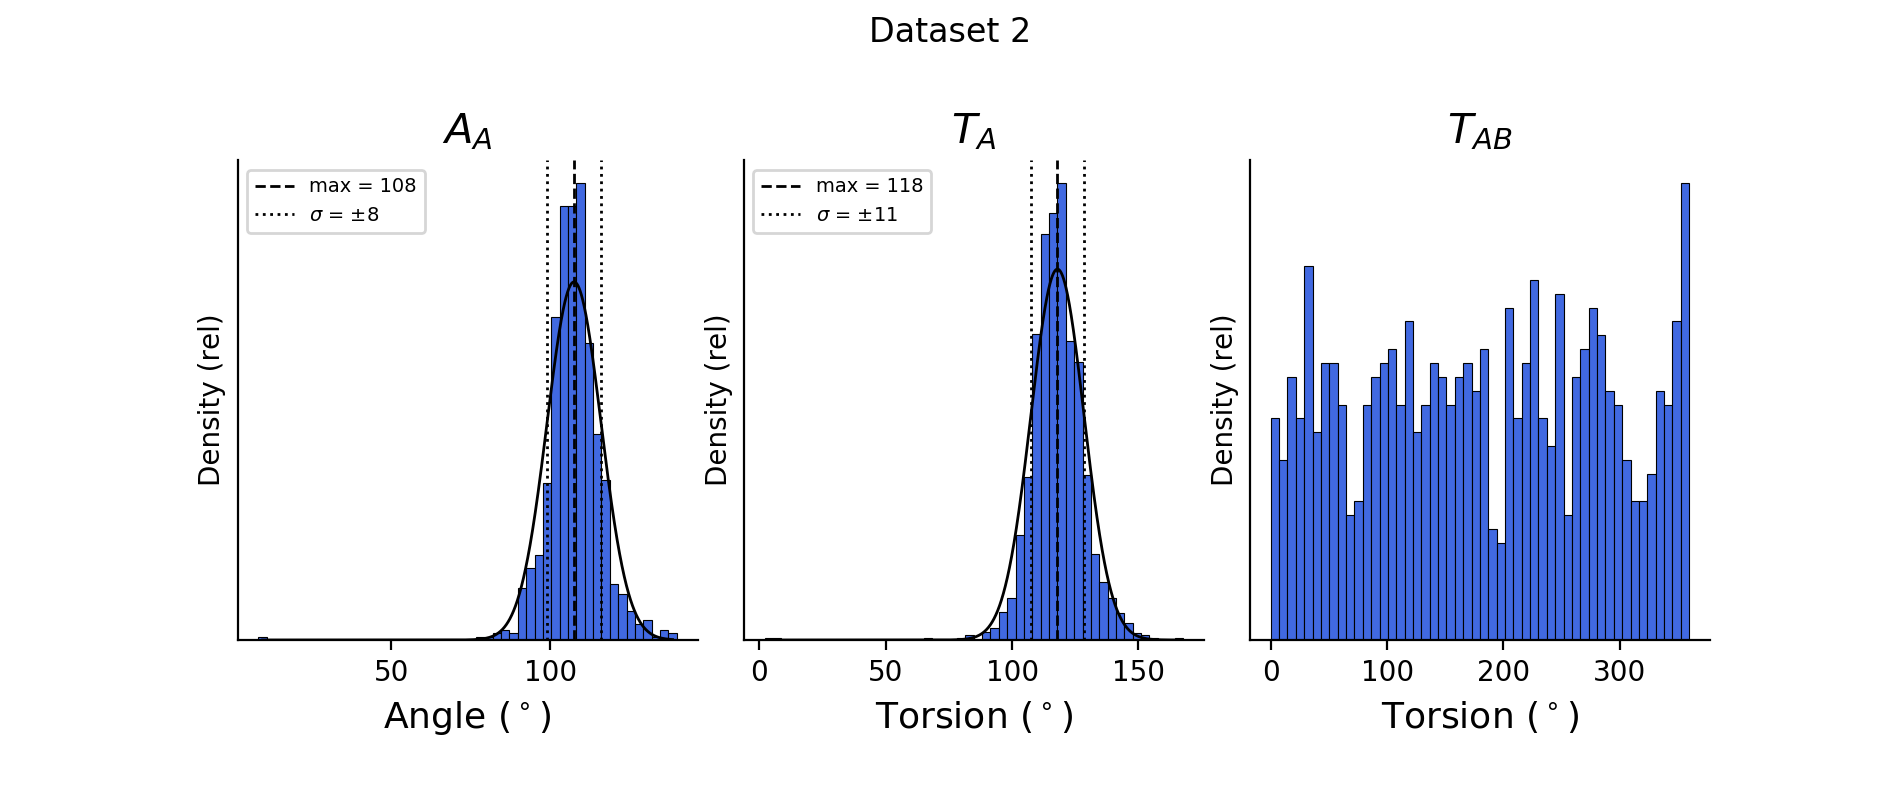

In [8]:
plot_geometry_dist(df.iloc[:, 3:6], [[st.norm], [st.norm], []], [r'Angle ($^\circ$)'] + [r'Torsion ($^\circ$)'] * 2,
                   'Dataset 2', skip=[3])

Thus we have obtained the optimal values, standard deviation / "flexibility" for the parametrized coordinationsphere of zinc and His/NE2 (as well as plotted them). The $T_{AB}$ parameter do not have well defined optimal values and is therefore modelled as "free" in the design. No fit is therefore carried out. 

## 2: Loop sampling using optimal values of $\phi$ and $\psi$ torsion angles

### Torsional degrees of freedom

Proteins have many torsional degrees of freedom and these are highlighted below with the lysine amino acid as an example.

<img src="images/dofs.png" width="200" align="center"/>

To effeciently sample proteins, these degrees of freedom have to be appropiately sampled. In the current design, loop structures are sampled at certain values for the $\phi$ and $\psi$ torsion angles. $\omega$ and $\chi$ torsion angles are not considered since $\omega$ torsion angles are very restricted and the loop sampling in this case takes place without sidechains, that is without the $\chi$ torsion angles being present.

### Sampling of $\phi$ and $\psi$ torsion angles

In order to sample the $\phi$ and $\psi$ torsion angles appropiately,  $\phi$ and $\psi$ torsion angles were analysed from high resolution crystal structures in the [*Top 8000*](http://kinemage.biochem.duke.edu/databases/top8000.php) dataset. The following analysis will first explore the space of $\phi$ and $\psi$ torsion angle values, and then it will be discussed how loops can be appropiately sampled by splitting the $\phi$ and $\psi$ torsion angles into ABEGO bins and optimal grid points.

## Analysis

### Read in the dataset

The dataset containing the observed values for $\phi$ and $\psi$-torsion angles are available in the data folder. These are read in below.

In [9]:
df = pd.read_table('data/list_of_torsion_angles_filtered.txt', sep=",",
                   engine='python', names=["phi", "psi"], header=None,)

df["phi"] = df["phi"].str.replace('(', '')
df["psi"] = df["psi"].str.replace(')', '')
df.index.name = "Observations"
df = df.astype("float64")
df = df.drop(index=df.loc[df.phi > 180].index) # remove a spurios value
df.head()

,phi,psi
Observations,,
0,89.405712,-48.291563
1,-79.036521,116.287120
2,-63.970447,-15.829115
3,-133.258338,155.568404
4,93.613321,160.085210


### $\phi$ and $\psi$ torsion angle space

The following code will produce two different [Ramachandran plots](https://en.wikipedia.org/wiki/Ramachandran_plot). A Ramachandran plot visualizes the allowed regional spaces of $\phi$ and $\psi$ torsion angles.

<IPython.core.display.Javascript object>


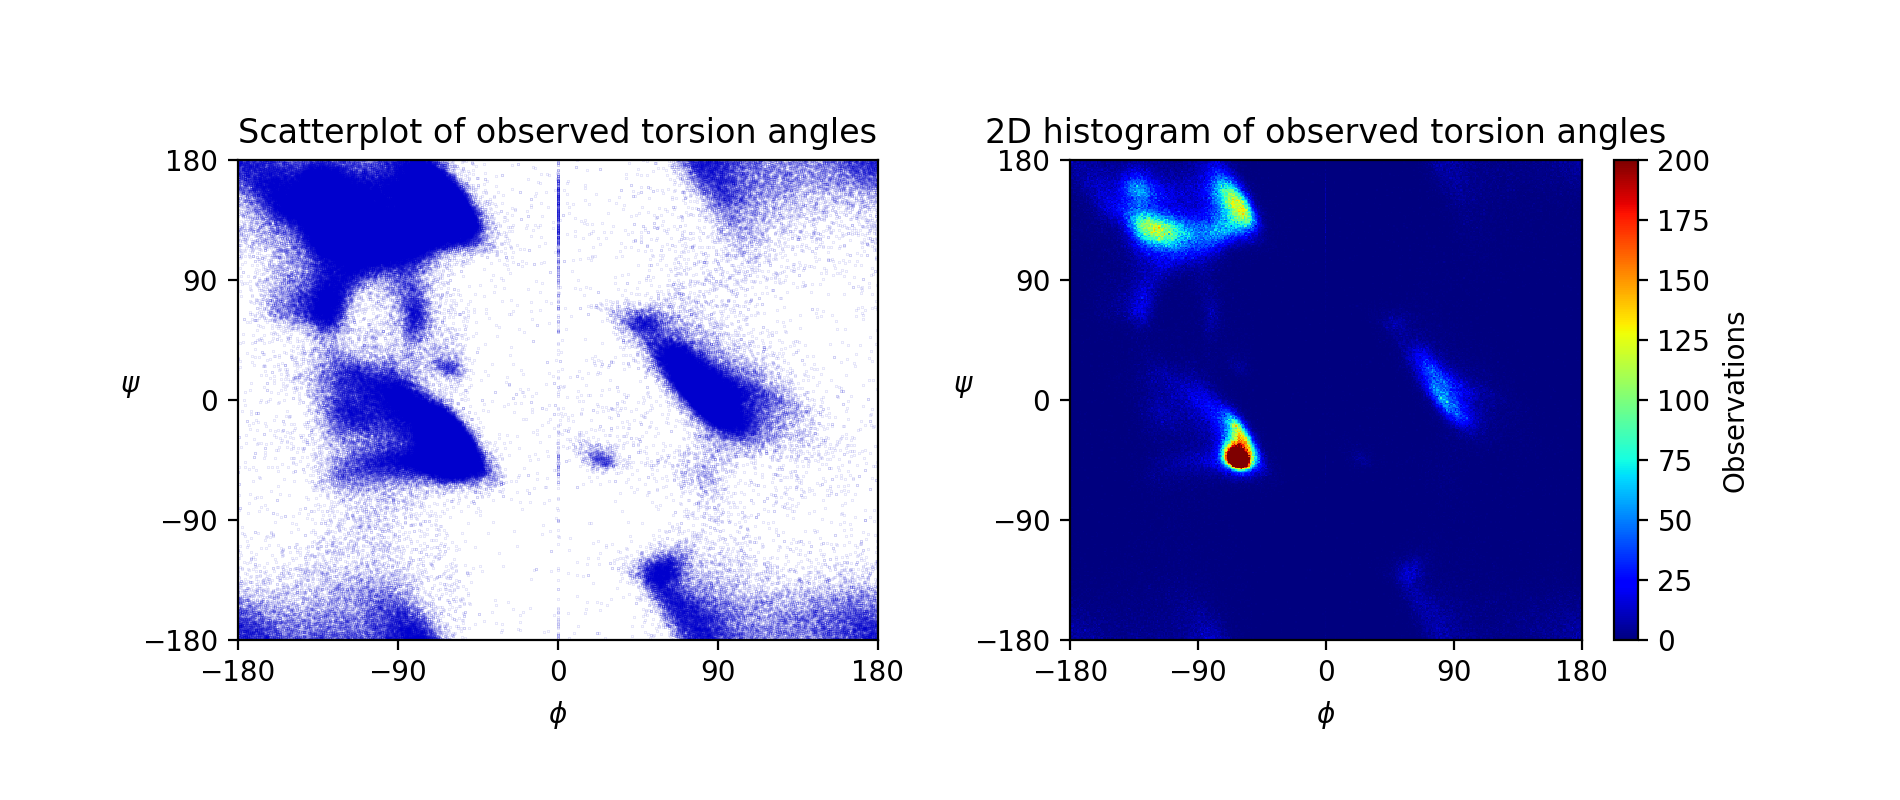

In [10]:
# Create and adjust figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9.5,4))
fig.subplots_adjust(left=None, bottom=0.2, right=None, top=0.8, wspace=0.3, hspace=0.2)

# Plot a scatter plot on the first axes and a 2D histogram for the second axes
ax1.scatter(df.iloc[:,0], df.iloc[:,1], s=0.001, c="mediumblue")
im = ax2.hist2d(df.iloc[:,0], df.iloc[:,1], (360, 360), vmin=0, vmax=200, cmap='jet')
fig.colorbar(im[3], label='Observations')

# Set limits, labels and ticks for both axes
ax1.set(ylim=(-180,180), xlim = (-180,180), yticks=range(-180, 181, 90), xticks=range(-180, 181, 90)
        , xlabel=r'$\phi$', title='Scatterplot of observed torsion angles')
ax2.set(ylim=(-180,180), xlim = (-180,180), yticks=range(-180, 181, 90), xticks=range(-180, 181, 90)
        , xlabel=r'$\phi$', title='2D histogram of observed torsion angles')
ax1.set_ylabel(r'$\psi$', rotation=0)
ax2.set_ylabel(r'$\psi$', rotation=0)



plt.show()

The left figure shows a scatter plot of all the data points in the dataset in blue. From this figure it is clear that the $\phi$ and $\psi$ torsion angles only take certain values, indicated by large regions lacking datapoints. The right figure shows a 2D histogram with $360^2$ bins and a color scheme indicating the observed values maxing out at 200 observations. In this figure it is even more clear that very specific regions are preferred, in particular the region in the top left corner and middle left region. Proteins form characteristic secondary structures called $\beta$-sheets and $\alpha$-helices and in these structures the $\phi$ and $\psi$ torsion angles of the residues have the values observed in the top left corner and middle left region respectively. When modelling $\beta$-sheets and $\alpha$-helices one would want to limit the $\phi$ and $\psi$ torsion angles to these regions respectively

### ABEGO bins and loop sampling

Loop regions are not as restricted as $\beta$-sheets and $\alpha$-helices. The $\phi$ and $\psi$ torsion angles can take a mixture of the different torsion angle values, including the ones seen in $\beta$-sheets and $\alpha$-helices. But when it comes to loops that connect different secondary structure elements, the combination of different $\phi$ and $\psi$ torsion angles, as well as their lengths become important. See the following article for a reference: [Lin et al. - Control over overall shape and size in de novo designed proteins](https://www.pnas.org/content/112/40/E5478).

Before discussing this further we have to first discuss ABEGO bins. These are regions of a ramachandran plot constrained by specific $\phi$ and $\psi$ values. These are defined below.

- A (red): -180 ≤ φ < 0 and -75 ≤ ψ < 50.
- B (blue): -180 ≤ φ < 0 and 50 ≤ ψ < 180 or -180 ≤ ψ < -75. 
- E (yellow): 0 ≤ φ < 180 and 100 ≤ ψ < 180 or -180 ≤ ψ < -100. 
- G (green): 0 ≤ φ < 180 and -100 ≤ ψ < 100.

The color designation will be understable in a second. Why is O missing? It refers to the $\omega$ torsion angle and is not important in this discussion. 

We can make a scatter plot again using the color scheme above using the following code below. While we are at it, specific grid points will be loaded as well from the data folder, and plottet in a seperate plot. These will be discussed below. 

In [11]:
# Use Bolean masking to select the ABEGO bins. 
dA = df.loc[(df['phi'] < 0) & ((df['psi'] > -75) & ( df['psi'] < 50))]
dB = df.loc[(df['phi'] < 0) & (((df.psi > 50) & (df.psi < 180)) | (df.psi < -75))]
dE = df.loc[(df['phi'] > 0) & ((df.psi > 100) | (df.psi < -75))]
dG = df.loc[(df['phi'] > 0) & (df.psi > -100) & (df.psi < 100)]

<IPython.core.display.Javascript object>


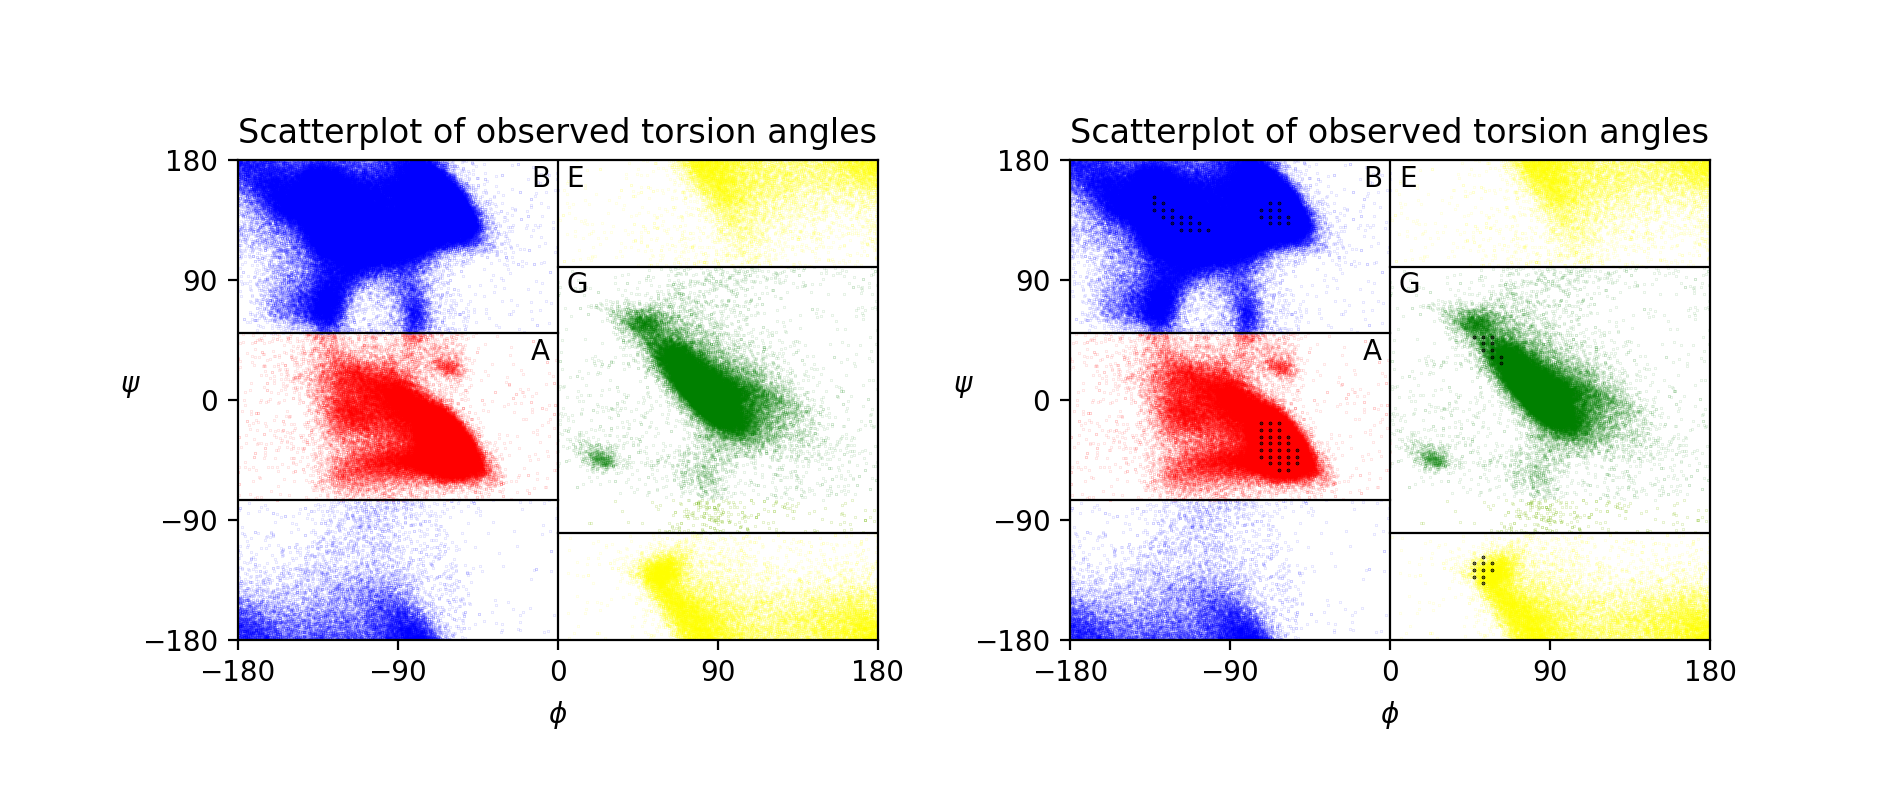

In [12]:
# Create and adjust plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9.5,4), )
fig.subplots_adjust(left=None, bottom=0.2, right=None, top=0.8, wspace=0.3, hspace=0.2)

# function for plotting most of the meat of the plots
def rama_abego_plot(ax):
    
    # Plot torsion angle values
    ax.scatter(dA.iloc[:,0], dA.iloc[:,1], s=0.001, c="red")
    ax.scatter(dB.iloc[:,0], dB.iloc[:,1], s=0.001, c="blue")
    ax.scatter(dE.iloc[:,0], dE.iloc[:,1], s=0.001, c="yellow")
    ax.scatter(dG.iloc[:,0], dG.iloc[:,1], s=0.001, c="green")

    # Plot lines
    ax.axhline(50, 0, 0.5, c='k', linewidth = 0.8)
    ax.axhline(-75, 0, 0.5, c='k', linewidth = 0.8)
    ax.axhline(100, 0.5, 1, c='k', linewidth = 0.8)
    ax.axhline(-100, 0.5, 1, c='k', linewidth = 0.8)
    ax.axvline(0, 0, 1, c='k', linewidth = 0.8)

    # Plot text
    ax.text(-15, 30, "A")
    ax.text(-15, 160, "B")
    ax.text(5, 160, "E")
    ax.text(5, 80, "G")
    
    # Setting limits, labels and ticks
    ax.set(ylim=(-180,180), xlim = (-180,180), yticks=range(-180, 181, 90), xticks=range(-180, 181, 90)
           , xlabel=r'$\phi$', title='Scatterplot of observed torsion angles')
    ax.set_ylabel(r'$\psi$', rotation=0)


    
# call function for each axes
rama_abego_plot(ax1)
rama_abego_plot(ax2)
    

# Read in grid points
dAgrid = pd.read_csv('data/Agrid.csv', sep=",", header=0, index_col=0)
dBgrid = pd.read_csv('data/Bgrid.csv', sep=",", header=0, index_col=0)
dEgrid = pd.read_csv('data/Egrid.csv', sep=",", header=0, index_col=0)
dGgrid = pd.read_csv('data/Ggrid.csv', sep=",", header=0, index_col=0)

# Scatterplot the grid points
ax2.scatter(dAgrid.iloc[:,0], dAgrid.iloc[:,1], c='k', s=0.1)
ax2.scatter(dBgrid.iloc[:,0], dBgrid.iloc[:,1], c='k', s=0.1)
ax2.scatter(dEgrid.iloc[:,0], dEgrid.iloc[:,1], c='k', s=0.1)
ax2.scatter(dGgrid.iloc[:,0], dGgrid.iloc[:,1], c='k', s=0.1)

plt.show()

The left figure is a scatterplot of the observed torsion angles indicating the ABEGO bins according to the colorscheme given above. From the reference linked earlier, certain combinations of these bins must exist for nicely formed loops connecting secondary structure elements. For instance, a nicely formed loop connecting an $\alpha$-helices and $\beta$-strand, one of the best combinations is a loop of 3 residues with the G-B-A combination. When sampling loop structures with only the $\phi$ and $\psi$ torsion angles as degrees of freedom (such as in the case of this design) the $\phi$ and $\psi$ values of the first residue of the loop must lie in the G bin (that is the green region), then the $\phi$ and $\psi$ values of the next residue must lie in the B region (that is the blue bin) and so on. An example of exactly this case is shown in the figure below:

<img src="images/GBA_loop.png" width="250" align="center"/>

How can we select good values to sample in each bin? The approach taken in this project was to divide the Ramachandran plot into 5x5 bins and then select the midpoints of each 5x5 bin in each ABEGO bin having the most observed datapoints. This is shown above in the right figure as black dots. The amount of points chosen is proportional to the probability of datapoint being in the respective ABEGO bin. 